In [16]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import SeparableConv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/Datasets/dataset_folder-9-classes_noSplit+testing_samples'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,severe-ventriculomegaly
1,cerebellah-hypoplasia
2,polencephaly
3,moderate-ventriculomegaly
4,normal
5,mild-ventriculomegaly
6,encephalocele
7,colphocephaly
8,arachnoid-cyst


In [44]:
train_data_dir =path
batch_size = 8
target_size = (224, 224)
validation_split = 0.2
lr = 0.0004

train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 1526 files belonging to 9 classes.
Using 1221 files for training.
Found 1526 files belonging to 9 classes.
Using 305 files for validation.


In [45]:
class_names = train.class_names
class_names

['arachnoid-cyst',
 'cerebellah-hypoplasia',
 'colphocephaly',
 'encephalocele',
 'mild-ventriculomegaly',
 'moderate-ventriculomegaly',
 'normal',
 'polencephaly',
 'severe-ventriculomegaly']

In [ ]:
def adjust_brightness(image, label, brightness_factor=1.3):
    """Apply brightness adjustment to image"""
    image = tf.cast(image, tf.float32)
    image = tf.clip_by_value(image * brightness_factor, 0, 255)
    image = tf.cast(image, tf.uint8)
    return image, label

train = train.map(lambda x, y: adjust_brightness(x, y, brightness_factor=1.3))
validation = validation.map(lambda x, y: adjust_brightness(x, y, brightness_factor=1.3))

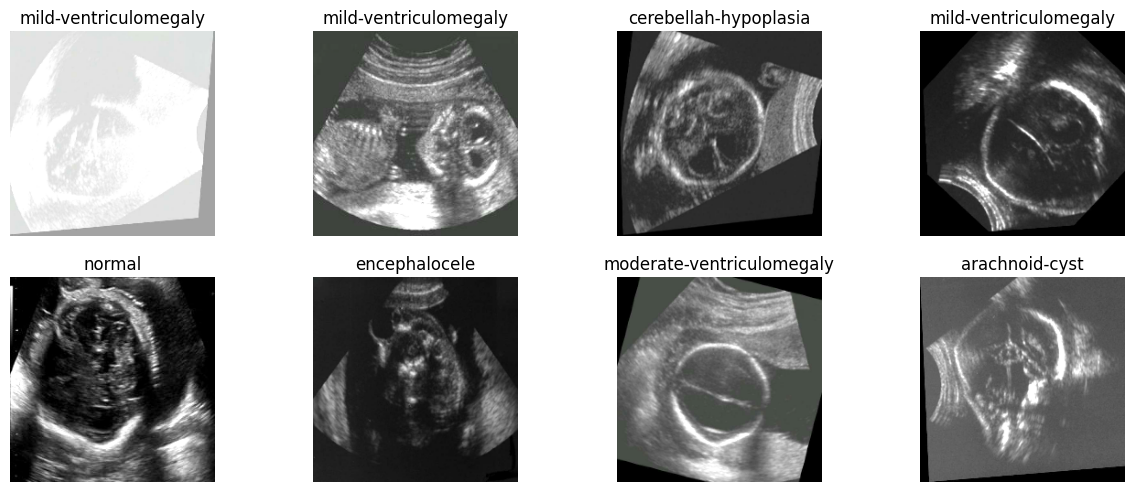

In [53]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(batch_size):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

all_labels = []
for _, labels in train:
    all_labels.extend(labels.numpy())

class_counts = np.bincount(all_labels)
print("Class distribution:", {class_names[i]: count for i, count in enumerate(class_counts)})

mod_vent_idx = class_names.index("moderate-ventriculomegaly")
print(f"moderate-ventriculomegaly class index: {mod_vent_idx}")

enc_idx = class_names.index("encephalocele")
print(f"encephalocele class index: {enc_idx}")

pol_idx = class_names.index("polencephaly")
print(f"polencephaly class index: {pol_idx}")

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

vent_penalty_factor = 0.75  
class_weights_array[mod_vent_idx] *= vent_penalty_factor

enc_penalty_factor = 0.8
class_weights_array[enc_idx] *= enc_penalty_factor

pol_penalty_factor = 1.2
class_weights_array[pol_idx] *= pol_penalty_factor

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Modified class weights:", class_weights)

Class distribution: {'arachnoid-cyst': np.int64(106), 'cerebellah-hypoplasia': np.int64(97), 'colphocephaly': np.int64(72), 'encephalocele': np.int64(114), 'mild-ventriculomegaly': np.int64(189), 'moderate-ventriculomegaly': np.int64(254), 'normal': np.int64(218), 'polencephaly': np.int64(72), 'severe-ventriculomegaly': np.int64(99)}
moderate-ventriculomegaly class index: 5
encephalocele class index: 3
encephalocele class index: 7
Modified class weights: {0: np.float64(1.279874213836478), 1: np.float64(1.3986254295532645), 2: np.float64(1.8842592592592593), 3: np.float64(0.9520467836257311), 4: np.float64(0.7178130511463845), 5: np.float64(0.4005905511811024), 6: np.float64(0.6223241590214067), 7: np.float64(2.261111111111111), 8: np.float64(1.3703703703703705)}


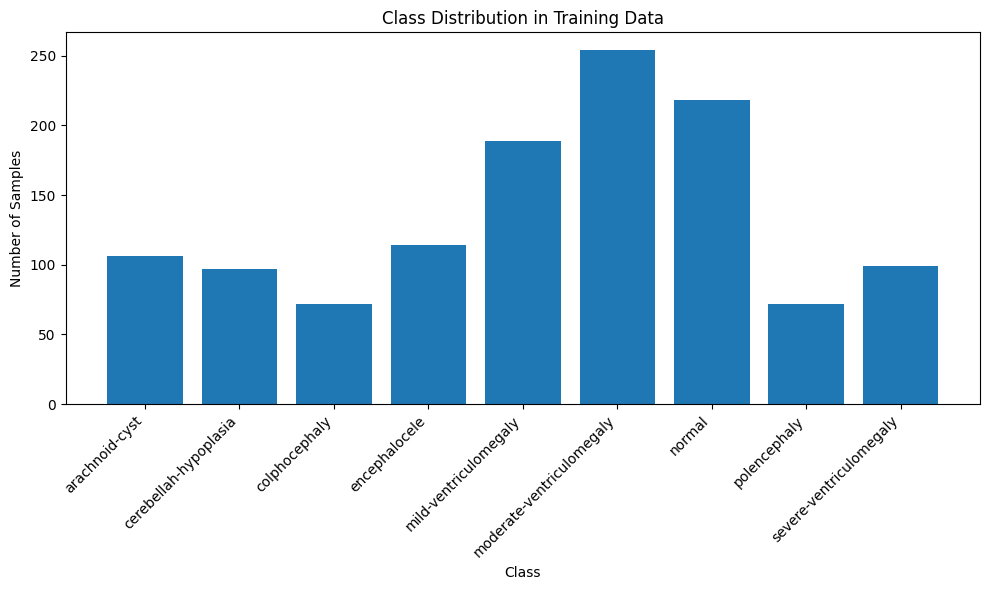

Class distribution: {'arachnoid-cyst': np.int64(106), 'cerebellah-hypoplasia': np.int64(97), 'colphocephaly': np.int64(72), 'encephalocele': np.int64(114), 'mild-ventriculomegaly': np.int64(189), 'moderate-ventriculomegaly': np.int64(254), 'normal': np.int64(218), 'polencephaly': np.int64(72), 'severe-ventriculomegaly': np.int64(99)}


In [ ]:
#computing class weights

plt.figure(figsize=(10, 6))
class_counts = np.bincount(all_labels)
plt.bar(range(len(class_names)), class_counts)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

print("Class distribution:", {class_names[i]: count for i, count in enumerate(class_counts)})

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(SeparableConv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer= l2(0.001)))
model.add(Activation('relu'))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(Dropout(0.3))  
model.add(Dense(64))  
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation = 'softmax', kernel_regularizer = l2(0.001)))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 7, 7, 16)       │        12,816 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,065,177 (76.54 MB)

 Trainable params: 40,505 (158.22 KB)

 Non-trainable params: 20,024,672 (76.39 MB)

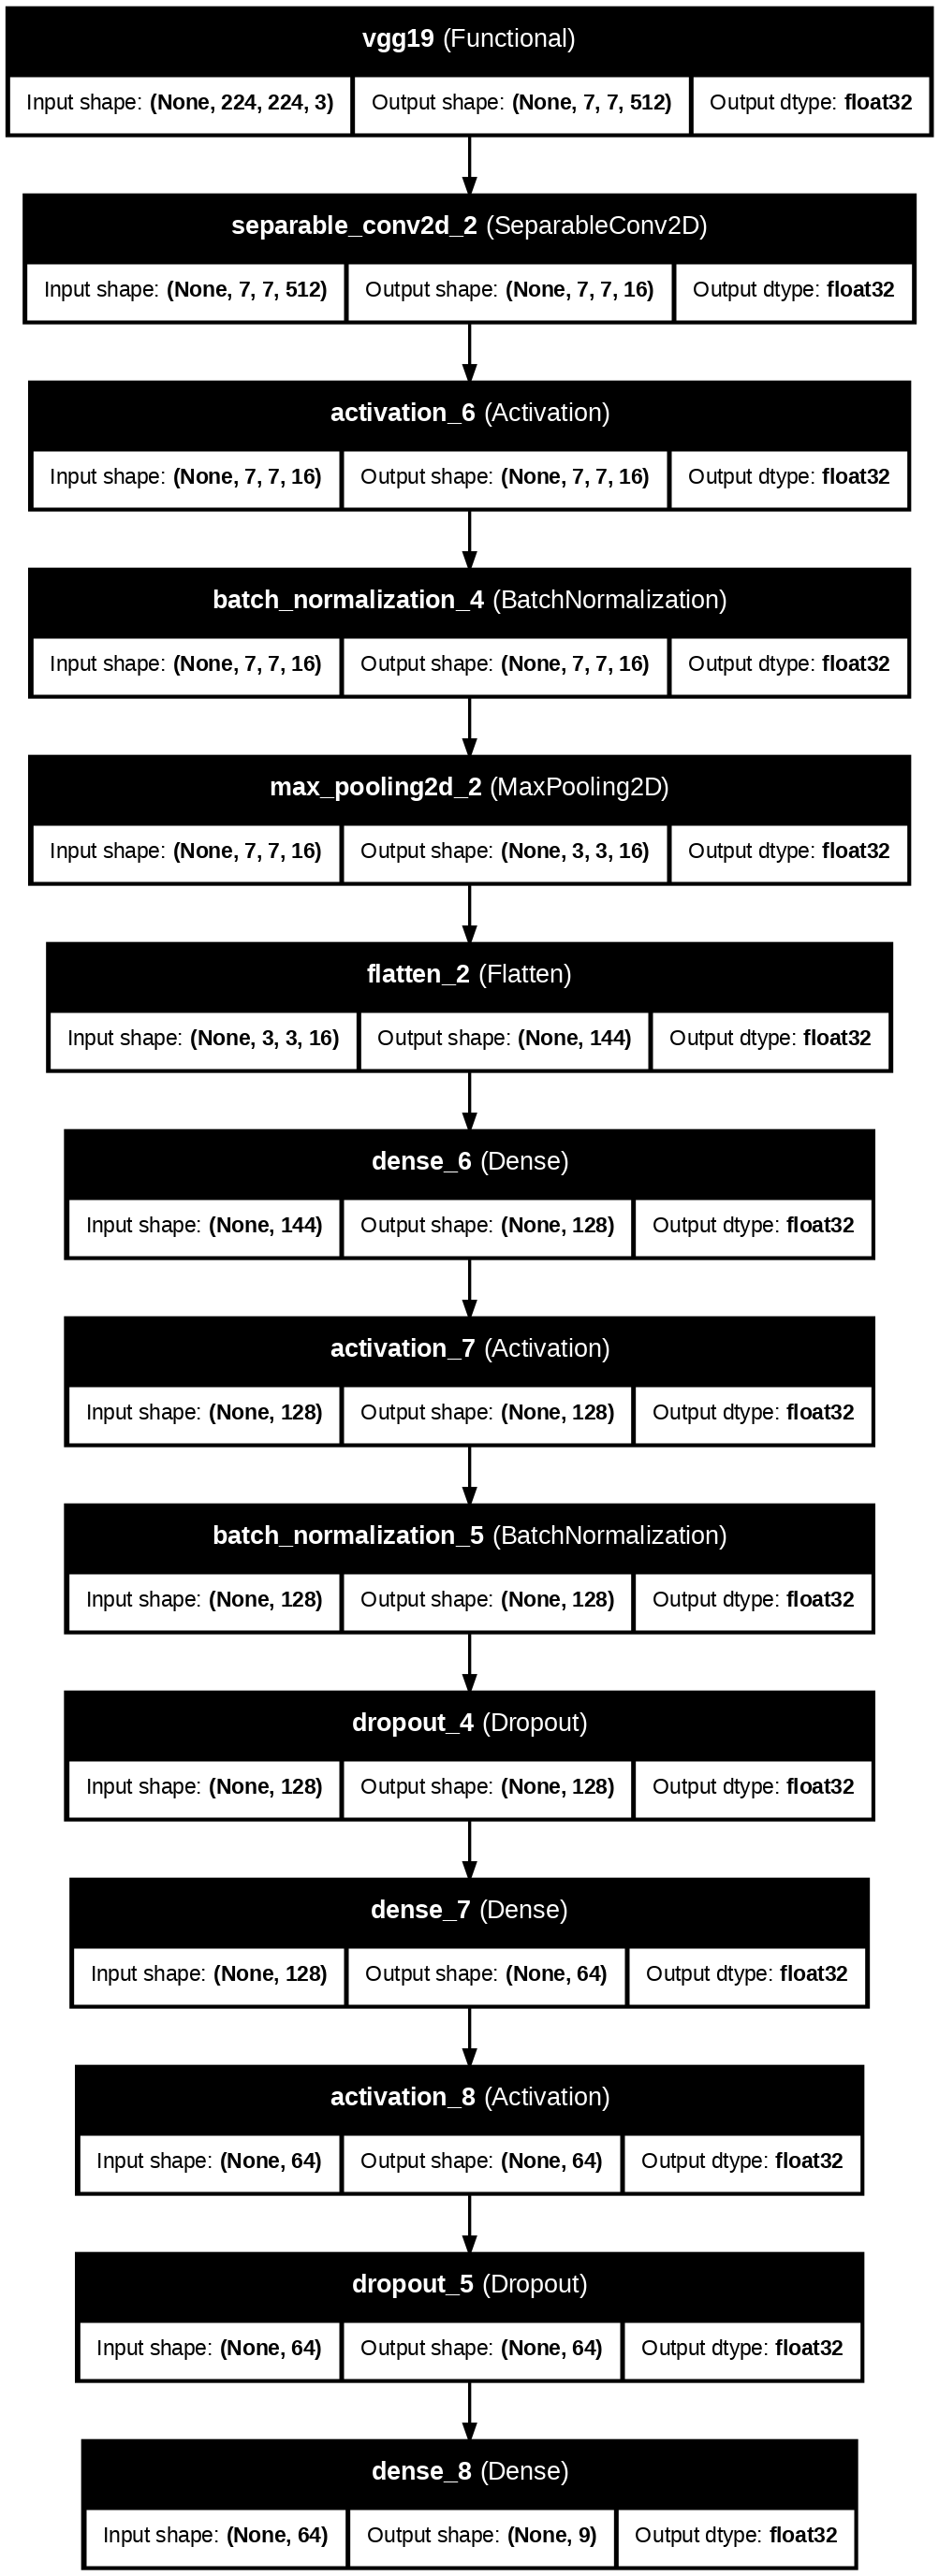

In [58]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("my_keras_model.keras", save_best_only=True)


early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)

model.compile(optimizer = optimizers.RMSprop(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    train,
    epochs=100,
    validation_data=validation,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight=class_weights  

)

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.5625 - loss: 1.3173 - val_accuracy: 0.6754 - val_loss: 1.1220
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.6104 - loss: 1.1186 - val_accuracy: 0.6852 - val_loss: 1.0335
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.6026 - loss: 1.0862 - val_accuracy: 0.7508 - val_loss: 0.9022
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.6713 - loss: 0.9520 - val_accuracy: 0.7902 - val_loss: 0.8379
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6977 - loss: 0.8682 - val_accuracy: 0.8000 - val_loss: 0.7755
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.7025 - loss: 0.8428 - val_accuracy: 0.8164 - val_loss: 0.7434
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.7239 - loss: 0.8034 - val_accuracy: 0.8230 - val_loss: 0.7080
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.7656 - loss

In [63]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9348 - loss: 0.3341
Test Loss = 0.27726489305496216
Test Accuracy = 0.9573770761489868


In [64]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.548731,1.375575,0.675410,1.122047
1,0.587224,1.194840,0.685246,1.033498
2,0.602785,1.119027,0.750820,0.902186
3,0.652744,0.995611,0.790164,0.837915
4,0.692056,0.894771,0.800000,0.775476
...,...,...,...,...
81,0.985258,0.104322,0.967213,0.310378
82,0.988534,0.081884,0.957377,0.324282
83,0.978706,0.101466,0.954098,0.322477
84,0.980344,0.106896,0.950820,0.339168


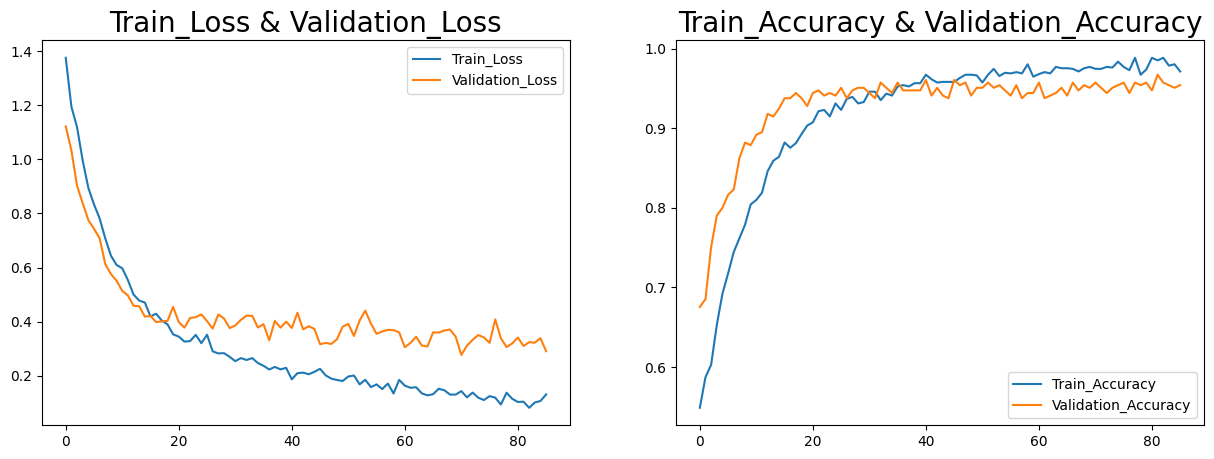

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [66]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step


,Actual,Prediction
0,4,4
1,4,4
2,1,1
3,4,0
4,4,4
...,...,...
300,8,8
301,7,7
302,0,0
303,3,3


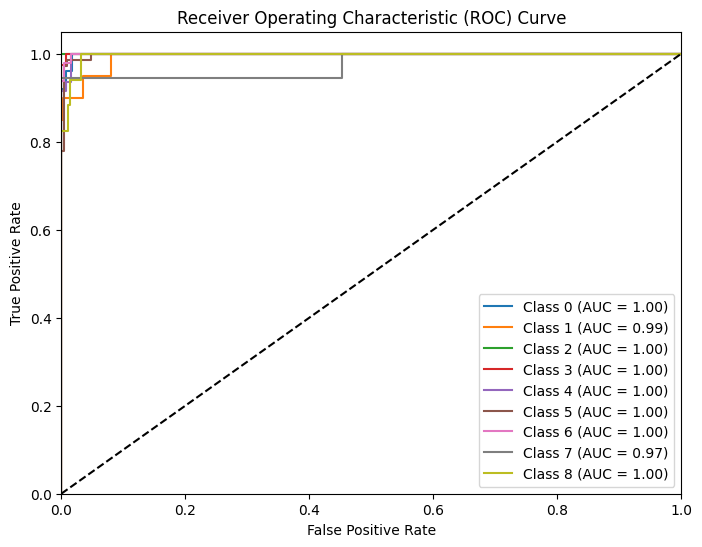

In [67]:
fpr  = dict()
tpr  = dict()
roc_auc = dict()

y_val_np = np.array(y_val).reshape(-1, 1)
n_classes = len(class_names)
onehot_encoder = OneHotEncoder(sparse_output=False, categories=[range(n_classes)])

y_val_onehot = onehot_encoder.fit_transform(y_val_np)
y_score = predictions

for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(9):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

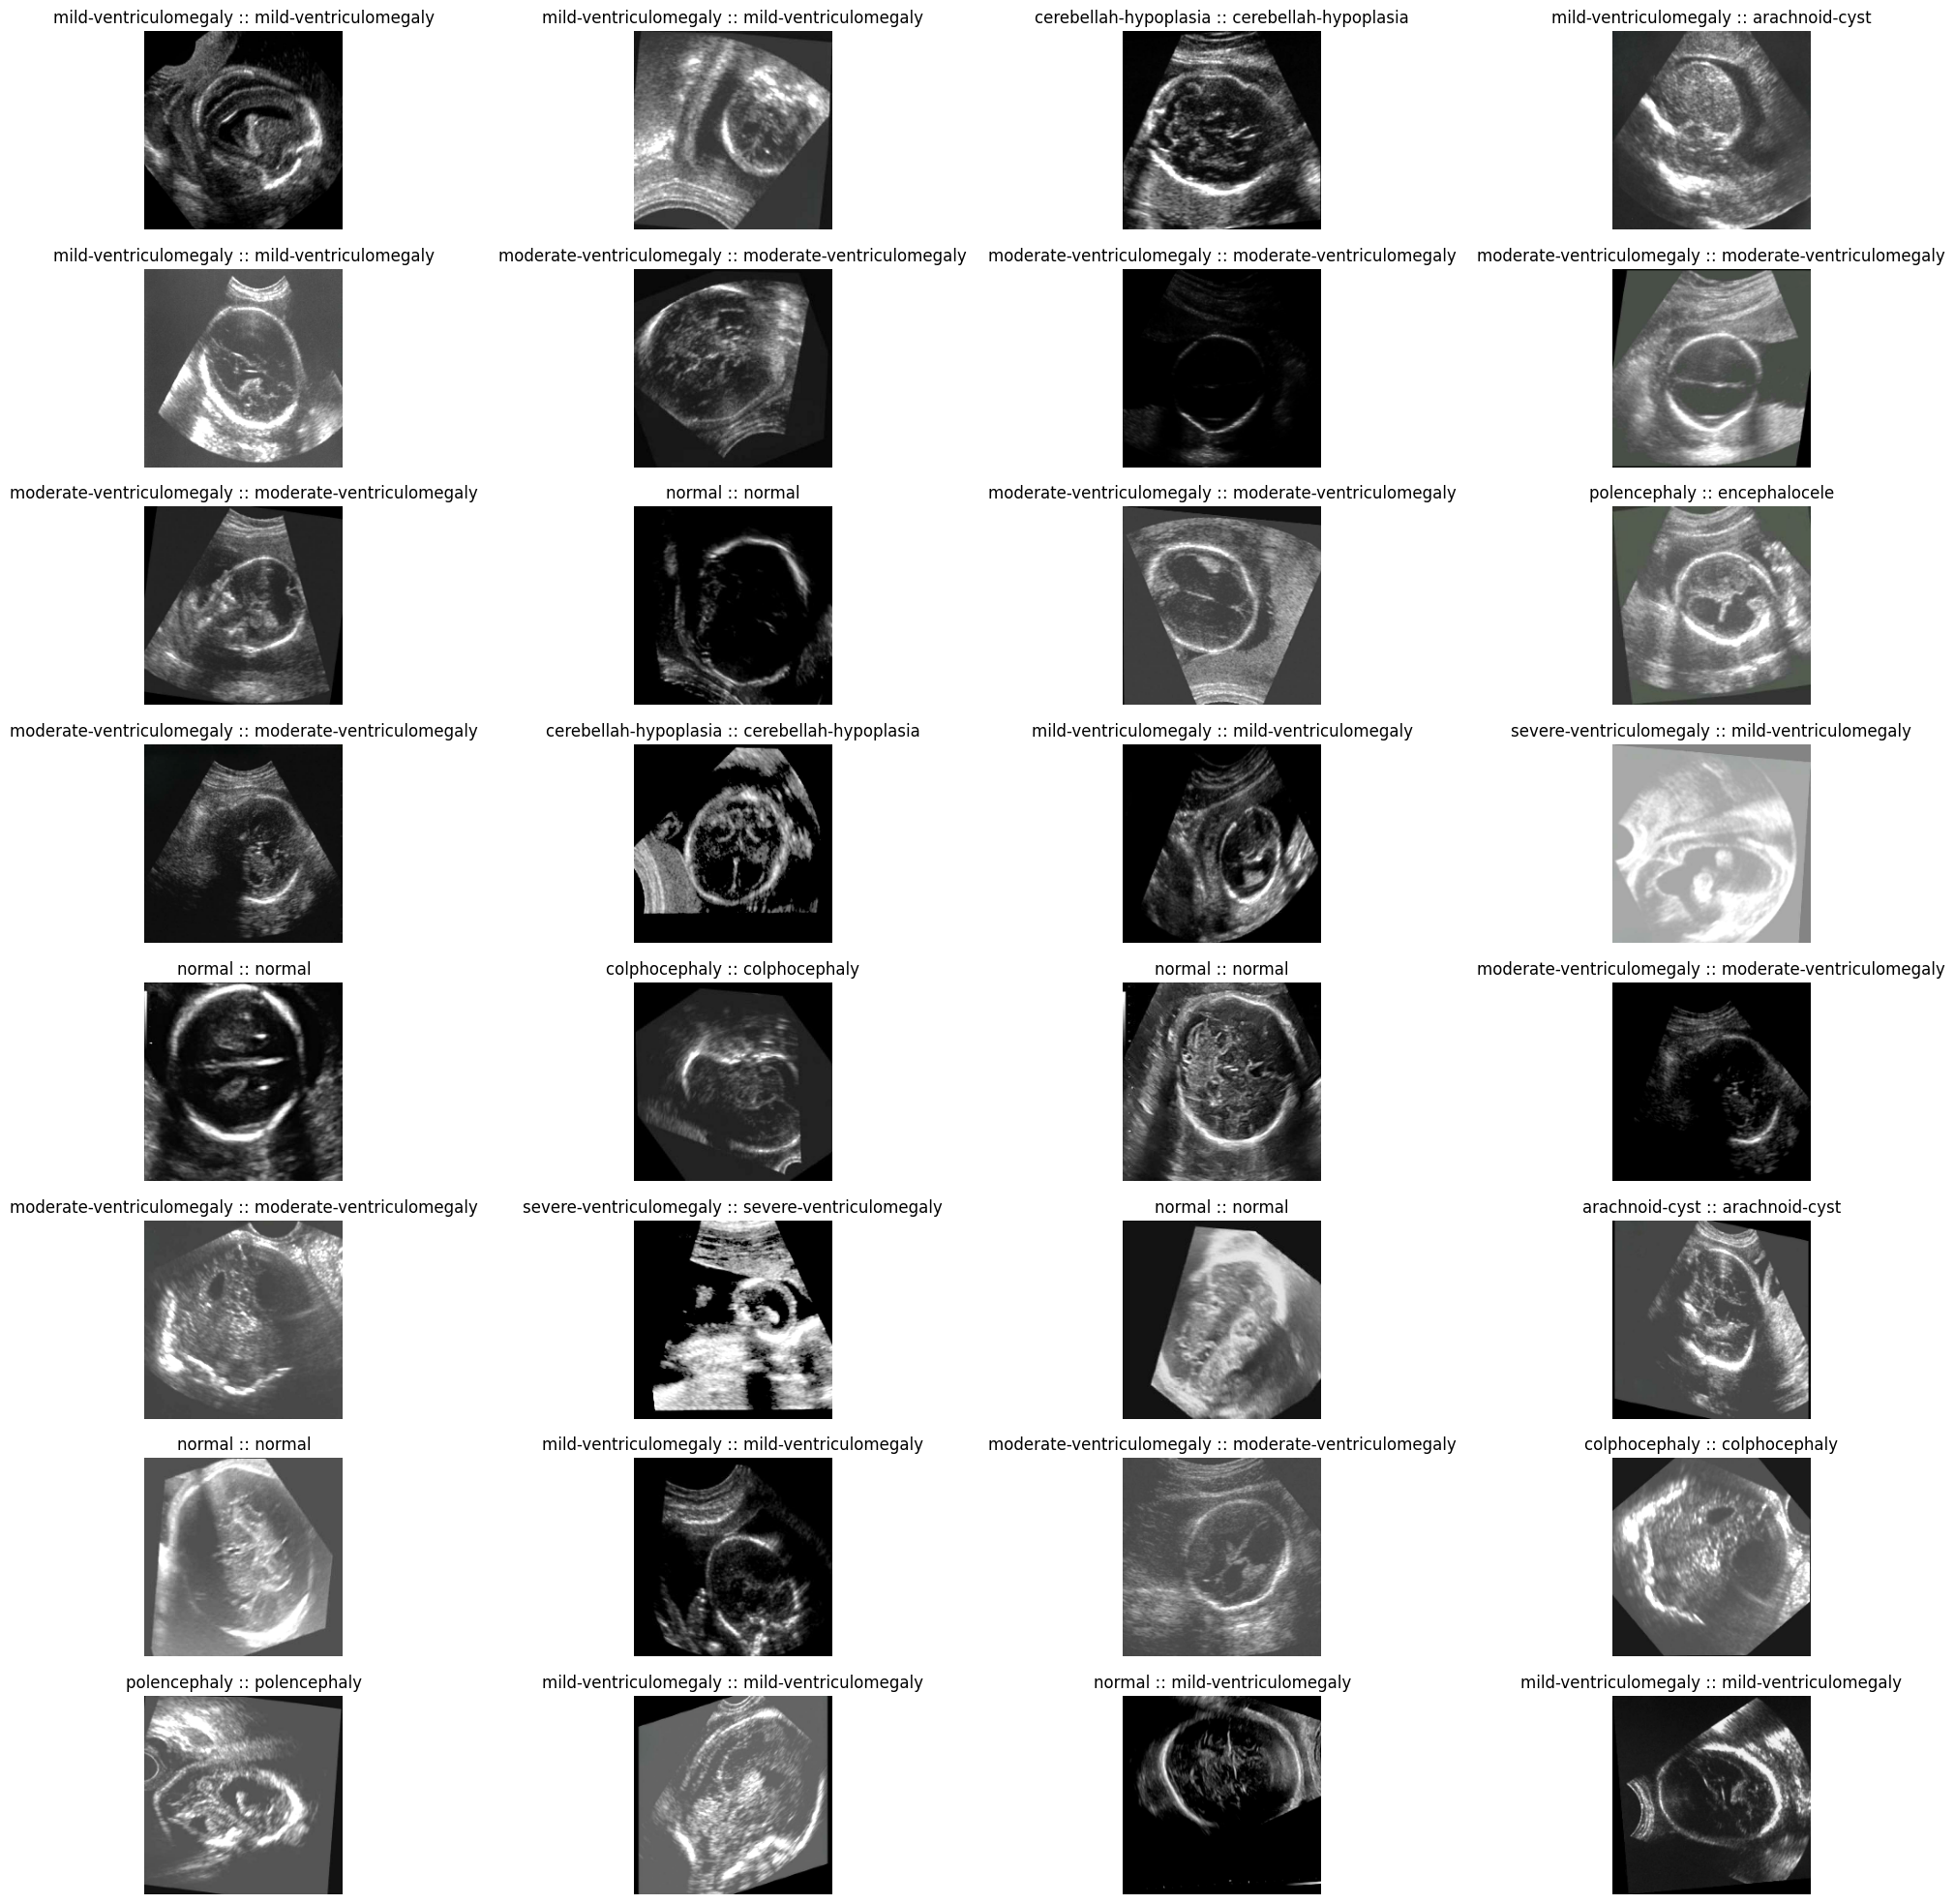

In [68]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

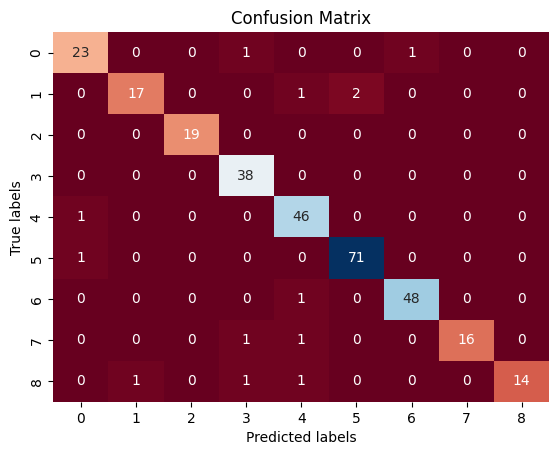

array([[23,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0, 17,  0,  0,  1,  2,  0,  0,  0],
       [ 0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 46,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 71,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 48,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0, 16,  0],
       [ 0,  1,  0,  1,  1,  0,  0,  0, 14]])

In [69]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [70]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.92      0.92      0.92        25
           1       0.94      0.85      0.89        20
           2       1.00      1.00      1.00        19
           3       0.93      1.00      0.96        38
           4       0.92      0.98      0.95        47
           5       0.97      0.99      0.98        72
           6       0.98      0.98      0.98        49
           7       1.00      0.89      0.94        18
           8       1.00      0.82      0.90        17

    accuracy                           0.96       305
   macro avg       0.96      0.94      0.95       305
weighted avg       0.96      0.96      0.96       305



In [ ]:
def save_final_model(model, base_name="vgg19_fetal_brain"):
    """Save the model in both keras and h5 formats"""
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    keras_path = os.path.join(save_dir, f"{base_name}.keras")
    model.save(keras_path)
    print(f"Model saved in Keras format: {keras_path}")

    h5_path = os.path.join(save_dir, f"{base_name}.h5")
    model.save(h5_path, save_format='h5')
    print(f"Model saved in H5 format: {h5_path}")

    return keras_path, h5_path

keras_path, h5_path = save_final_model(model)


Model saved in Keras format: saved_models/vgg19_fetal_brain.keras
Model saved in H5 format: saved_models/vgg19_fetal_brain.h5
